In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
from pathlib import Path

from post.files import parse_metrics_log, parse_job_log
from post.plots import get_figa, make_axis_great_again, plot_metrics, plot_losses, plot_lr
from post.utils import parse_epochs

In [3]:
tesi_folder = Path('~/Scuola/now/thesis').expanduser()
milestones = tesi_folder / 'milestones'
current_milestone = milestones / '12.05_20.05_near_complete_pipeline'

In [4]:
def plot_job(ax, job_id, title, training_batch_size, metrics_ylim):
    exp_name, train_data_amount, _, epochs, lr_reductions = parse_job_log(current_milestone / '{}.out'.format(job_id))
    batch_amount_per_epoch = np.ceil(train_data_amount / training_batch_size)
    n_epochs = max(int(5e2), len(epochs))
    xrange = np.arange(1, n_epochs + 1) * batch_amount_per_epoch
    
    if title:
        title = 'job #{}: "{}"'.format(job_id, title)
    else:
        title = ''
        
    plot_losses(
        ax, epochs, xrange,
        # normalize_loss=(0, 1),
        title=title, xlabel='# batch iterations'
    )
    
    plot_metrics(
        ax.twinx(), epochs, xrange,
        train_metric_ylim=metrics_ylim,
        eval_metric_ylim=metrics_ylim,
        metric_ylabel='average MPJPE relative to pelvis (mm)',
    )
    
    plot_lr(ax, lr_reductions, batch_amount_per_epoch)
    
    make_axis_great_again(ax, xlim=xrange, ylim=[0, 1e2], hide_y=True)

    
def plot_jobs(jobs, titles, training_batch_size=8, metrics_ylim=[0, 1e2]):
    fig, axis = get_figa(len(jobs), 1, heigth=12, width=30)  # 1 job foreach row
    
    if len(jobs) > 1:
        for ax, job_id, title in zip(axis.ravel(), jobs, titles):
            plot_job(ax, job_id, title, training_batch_size, metrics_ylim)
    else:
        plot_job(axis, jobs[0], titles[0], training_batch_size, metrics_ylim)

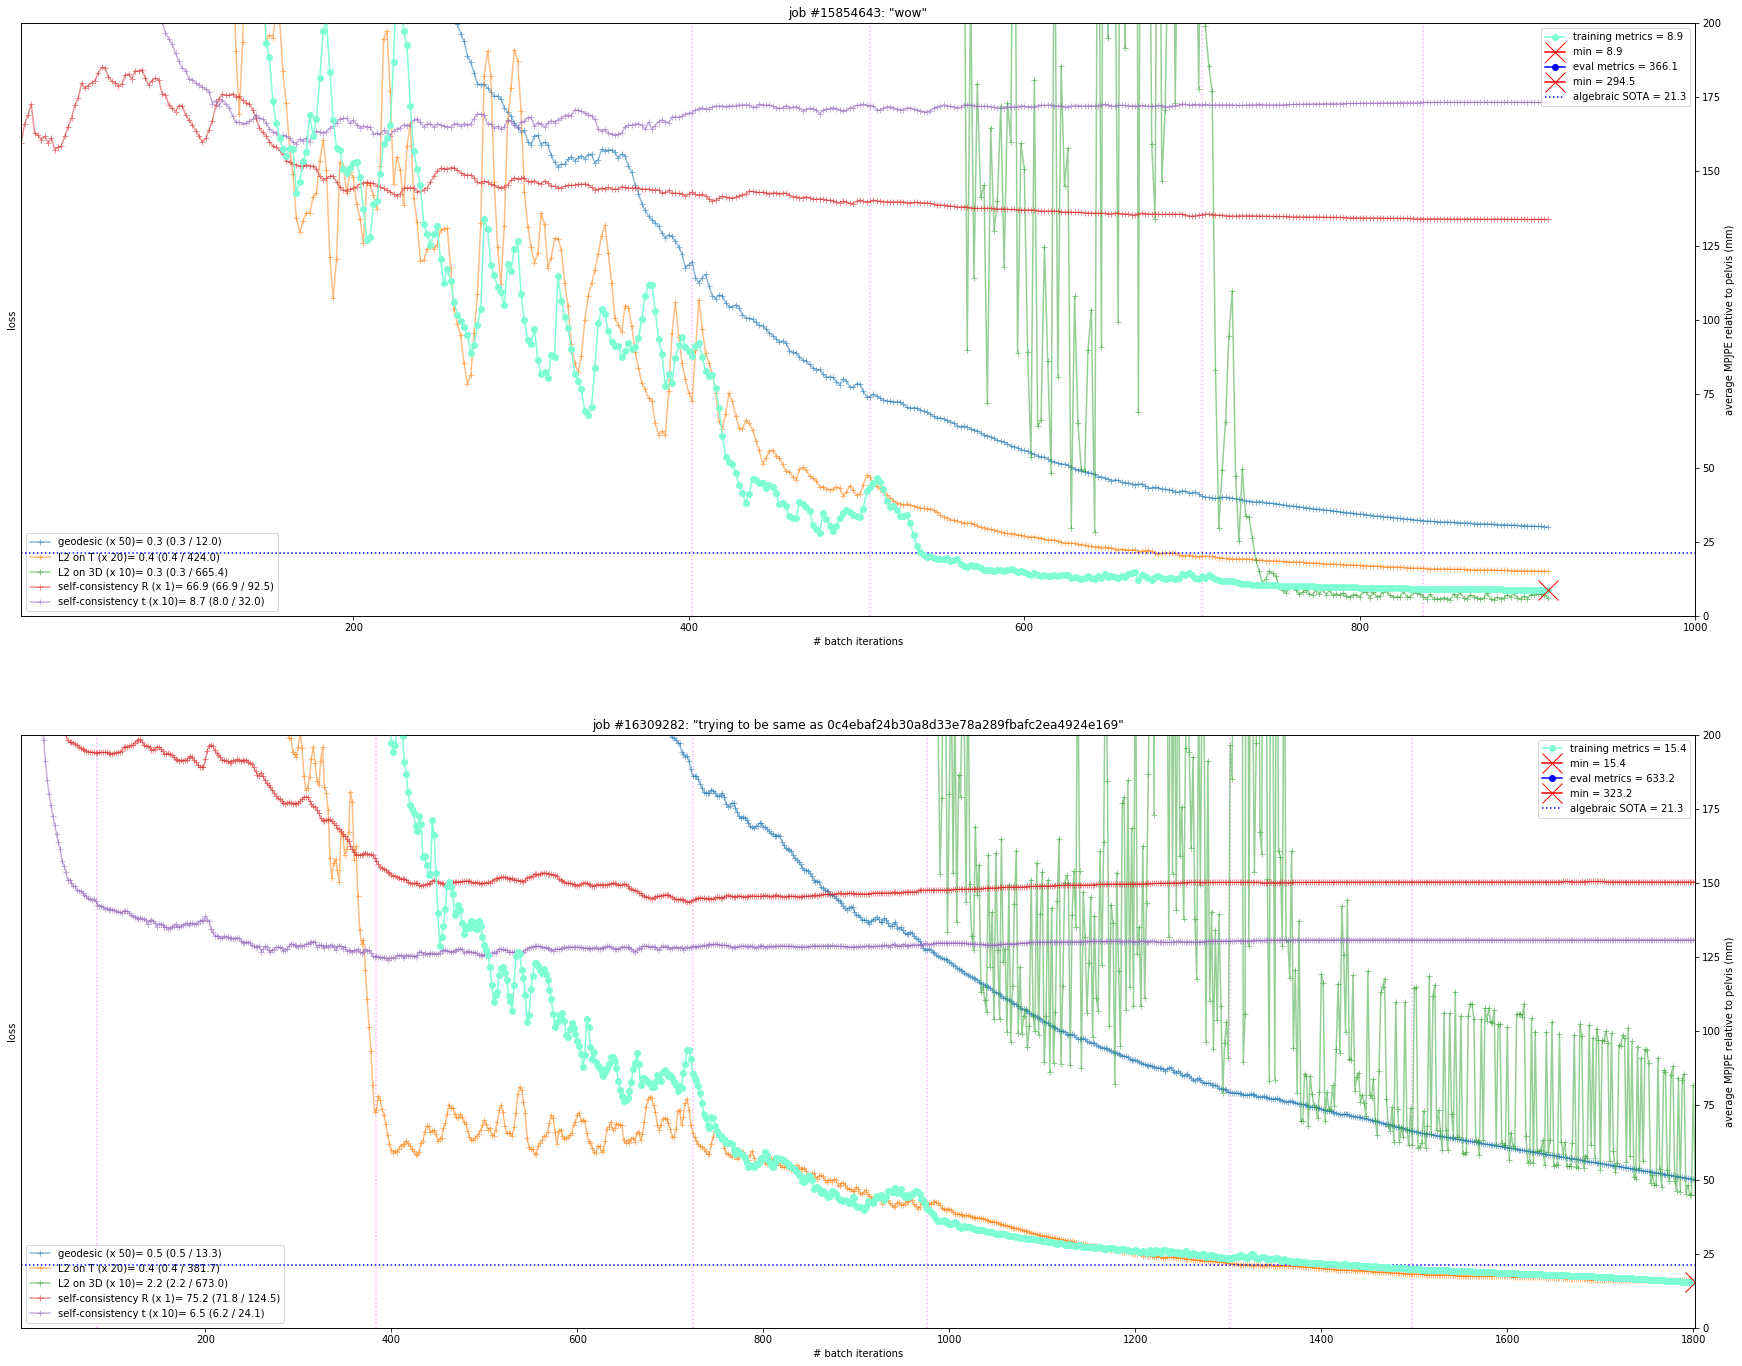

In [5]:
title = 'preprocess = {} | arch = {} | loss = {} | regime = {}'
common_setup = 'KISS (normalizing KPs), no lr decay'
jobs = list(zip(*[
    # ('15854643', 'wow'),  #  0c4ebaf24b30a8d33e78a289fbafc2ea4924e169
    # another baseline ('15926479', 'norm Fro, supervision: 3D, R | t'),
    
    ('16309282', 'trying to be same as 0c4ebaf24b30a8d33e78a289fbafc2ea4924e169'),  # 3D jiggly at end
    # todo check ('16214125', '15854643 long version')  #   training dataset length: 11872, validation dataset length: 703

    ('', 'Rodrigues 3D representation')
]))

plot_jobs(jobs[0], jobs[1], metrics_ylim=[0, 200])

In [11]:
import torch
from torch import nn


class RodriguesBlock(nn.Module):
    """ https://kornia.readthedocs.io/en/v0.1.2/_modules/torchgeometry/core/conversions.html#angle_axis_to_rotation_matrix """

    def __init__(self):
        super().__init__()

    @staticmethod
    def _compute_rotation_matrix(angle_axis, theta2, eps=1e-6):
        # We want to be careful to only evaluate the square root if the
        # norm of the angle_axis vector is greater than zero. Otherwise
        # we get a division by zero.
        k_one = 1.0
        theta = torch.sqrt(theta2)
        wxyz = angle_axis / (theta + eps)
        wx, wy, wz = torch.chunk(wxyz, 3, dim=1)
        cos_theta = torch.cos(theta)
        sin_theta = torch.sin(theta)

        r00 = cos_theta + wx * wx * (k_one - cos_theta)
        r10 = wz * sin_theta + wx * wy * (k_one - cos_theta)
        r20 = -wy * sin_theta + wx * wz * (k_one - cos_theta)
        r01 = wx * wy * (k_one - cos_theta) - wz * sin_theta
        r11 = cos_theta + wy * wy * (k_one - cos_theta)
        r21 = wx * sin_theta + wy * wz * (k_one - cos_theta)
        r02 = wy * sin_theta + wx * wz * (k_one - cos_theta)
        r12 = -wx * sin_theta + wy * wz * (k_one - cos_theta)
        r22 = cos_theta + wz * wz * (k_one - cos_theta)
        rotation_matrix = torch.cat(
            [r00, r01, r02, r10, r11, r12, r20, r21, r22], dim=1)
        return rotation_matrix.view(-1, 3, 3)

    @staticmethod
    def _compute_rotation_matrix_taylor(angle_axis):
        rx, ry, rz = torch.chunk(angle_axis, 3, dim=1)
        k_one = torch.ones_like(rx)
        rotation_matrix = torch.cat(
            [k_one, -rz, ry, rz, k_one, -rx, -ry, rx, k_one], dim=1)
        return rotation_matrix.view(-1, 3, 3)

    def forward(self, angle_axis):
        """ https://en.wikipedia.org/wiki/Axis%E2%80%93angle_representation """

        # stolen from ceres/rotation.h

        _angle_axis = torch.unsqueeze(angle_axis, dim=1)
        theta2 = torch.matmul(_angle_axis, _angle_axis.transpose(1, 2))
        theta2 = torch.squeeze(theta2, dim=1)

        # compute rotation matrices
        rotation_matrix_normal = self._compute_rotation_matrix(angle_axis, theta2)
        rotation_matrix_taylor = self._compute_rotation_matrix_taylor(angle_axis)

        # create mask to handle both cases
        eps = 1e-6
        mask = (theta2 > eps).view(-1, 1, 1).to(theta2.device)
        mask_pos = (mask).type_as(theta2)
        mask_neg = (mask == False).type_as(theta2)  # noqa

        # create output pose matrix
        batch_size = angle_axis.shape[0]
        rotation_matrix = torch.eye(4).to(angle_axis.device).type_as(angle_axis)
        rotation_matrix = rotation_matrix.view(1, 4, 4).repeat(batch_size, 1, 1)
        # fill output matrix with masked values
        rotation_matrix[..., :3, :3] = \
            mask_pos * rotation_matrix_normal + mask_neg * rotation_matrix_taylor
        
        return rotation_matrix[:, :3, :3]  # remove 0, 0, 0, 1 and 0s on the right => Nx3x3


batch_size = 8
x = torch.rand(batch_size, 3)


print(RodriguesBlock()(x))
angle_axis_to_rotation_matrix(x)

tensor([[[ 0.6093, -0.7046,  0.3638],
         [ 0.7761,  0.4357, -0.4560],
         [ 0.1627,  0.5602,  0.8122]],

        [[ 0.6256, -0.4377,  0.6458],
         [ 0.7706,  0.4760, -0.4239],
         [-0.1219,  0.7628,  0.6350]],

        [[ 0.7885, -0.2507,  0.5616],
         [ 0.5012,  0.7912, -0.3505],
         [-0.3565,  0.5578,  0.7495]],

        [[ 0.5085, -0.2281,  0.8303],
         [ 0.6471,  0.7374, -0.1937],
         [-0.5681,  0.6357,  0.5226]],

        [[ 0.4798, -0.0845,  0.8733],
         [ 0.7109,  0.6208, -0.3305],
         [-0.5143,  0.7794,  0.3579]],

        [[ 0.7494, -0.1832,  0.6363],
         [ 0.5667,  0.6746, -0.4731],
         [-0.3426,  0.7151,  0.6094]],

        [[ 0.8671,  0.0529,  0.4954],
         [ 0.3418,  0.6604, -0.6686],
         [-0.3625,  0.7491,  0.5545]],

        [[ 0.7554,  0.1756,  0.6313],
         [ 0.3942,  0.6478, -0.6519],
         [-0.5234,  0.7413,  0.4202]]])


tensor([[[ 0.6093, -0.7046,  0.3638],
         [ 0.7761,  0.4357, -0.4560],
         [ 0.1627,  0.5602,  0.8122]],

        [[ 0.6256, -0.4377,  0.6458],
         [ 0.7706,  0.4760, -0.4239],
         [-0.1219,  0.7628,  0.6350]],

        [[ 0.7885, -0.2507,  0.5616],
         [ 0.5012,  0.7912, -0.3505],
         [-0.3565,  0.5578,  0.7495]],

        [[ 0.5085, -0.2281,  0.8303],
         [ 0.6471,  0.7374, -0.1937],
         [-0.5681,  0.6357,  0.5226]],

        [[ 0.4798, -0.0845,  0.8733],
         [ 0.7109,  0.6208, -0.3305],
         [-0.5143,  0.7794,  0.3579]],

        [[ 0.7494, -0.1832,  0.6363],
         [ 0.5667,  0.6746, -0.4731],
         [-0.3426,  0.7151,  0.6094]],

        [[ 0.8671,  0.0529,  0.4954],
         [ 0.3418,  0.6604, -0.6686],
         [-0.3625,  0.7491,  0.5545]],

        [[ 0.7554,  0.1756,  0.6313],
         [ 0.3942,  0.6478, -0.6519],
         [-0.5234,  0.7413,  0.4202]]])